# Optimized Edge Laplacian Embedding for Link Prediction
This notebook demonstrates how to compute edge embeddings using the edge Laplacian for link prediction on a subgraph of the SNAP Amazon co-purchase dataset, using snowball sampling and various optimizations to reduce computation time and memory usage.

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import os
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from scipy.sparse import csr_matrix, save_npz, load_npz
import joblib
np.random.seed(42)

In [3]:
# Step 1: Load and sample subgraph using snowball sampling
# Parameters
target_size = 20000

# Load full graph
print("Loading full graph...")
G_full = nx.read_edgelist("amazon0302.txt", nodetype=int)

# Randomized snowball sampling
print(f"Performing snowball sampling until {target_size} nodes are reached...")

def snowball_sample_until_n_nodes(G, target_size):
    if target_size >= G.number_of_nodes():
        return G.copy()

    # Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    while queue and len(visited) < target_size:
        current = queue.pop(0)
        neighbors = list(G.neighbors(current))
        random.shuffle(neighbors)  # add randomness

        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= target_size:
                    break

    return G.subgraph(visited).copy()

# Sample the graph
G_sub = snowball_sample_until_n_nodes(G_full, target_size)

# Clean and finalize
G_sub = nx.Graph(G_sub)
G_sub.remove_edges_from(nx.selfloop_edges(G_sub))

print(f"Sampled subgraph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

Loading full graph...
Performing snowball sampling until 20000 nodes are reached...
Sampled subgraph: 20000 nodes, 50506 edges


In [4]:
# Step 2: Compute sparse incidence matrix and edge Laplacian
print("Computing sparse incidence matrix and edge Laplacian...")
def snowball_sample_until_n_nodes(G, target_size):
    if target_size >= G.number_of_nodes():
        return G.copy()

    # Step 1: Start from a random node
    start_node = random.choice(list(G.nodes()))
    visited = set([start_node])
    queue = [start_node]

    # Step 2: BFS-like expansion until we reach target_size nodes
    while queue and len(visited) < target_size:
        current = queue.pop(0)
        neighbors = list(G.neighbors(current))
        random.shuffle(neighbors)  # Add randomness in expansion

        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) >= target_size:
                    break

    # Step 3: Return the induced subgraph
    return G.subgraph(visited).copy()
# Ensure B is sparse, then perform multiplication in sparse format
B = nx.incidence_matrix(G_sub, oriented=False).tocsr()  # ensure B is sparse CSR
Le = csr_matrix(B.T @ B)

Computing sparse incidence matrix and edge Laplacian...


In [5]:
# Then use TruncatedSVD
svd = TruncatedSVD(n_components=5)
edge_embeddings = svd.fit_transform(Le)

In [6]:
# Step 4: Prepare subsampled positive and balanced negative samples
edge_list = list(G_sub.edges())
n_pos = int(0.1 * len(edge_list))
positive_edges = np.array(edge_list)
positive_edges = positive_edges[np.random.choice(len(positive_edges), n_pos, replace=False)]
labels_pos = np.ones(len(positive_edges))
non_edges = np.array(list(nx.non_edges(G_sub)))
negative_edges = non_edges[np.random.choice(len(non_edges), len(positive_edges), replace=False)]
labels_neg = np.zeros(len(negative_edges))
edges_all = np.concatenate([positive_edges, negative_edges])
labels_all = np.concatenate([labels_pos, labels_neg])
edges_train, edges_test, y_train, y_test = train_test_split(edges_all, labels_all, test_size=0.3, random_state=42)

In [7]:
# Step 5: Create edge index map
edge_index_map = {tuple(sorted(edge)): idx for idx, edge in enumerate(G_sub.edges())}

def get_edge_embedding(edge, edge_index_map, edge_embeddings):
    node1, node2 = edge
    incident_edges = list(G_sub.edges(node1)) + list(G_sub.edges(node2))
    indices = [edge_index_map[tuple(sorted(e))] for e in incident_edges if tuple(sorted(e)) in edge_index_map]
    if indices:
        return edge_embeddings[indices].mean(axis=0)
    else:
        return np.zeros(edge_embeddings.shape[1])

In [8]:
# Step 6: Generate training and testing feature matrices
print("Generating feature matrices...")
X_train = np.array([get_edge_embedding(e, edge_index_map, edge_embeddings) for e in edges_train])
X_test = np.array([get_edge_embedding(e, edge_index_map, edge_embeddings) for e in edges_test])

Generating feature matrices...


In [10]:
# Step 7: Train and evaluate MLP classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

print("Training MLP classifier...")
clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Training MLP classifier...
              precision    recall  f1-score   support

         0.0       0.64      0.43      0.51      1462
         1.0       0.59      0.78      0.67      1568

    accuracy                           0.61      3030
   macro avg       0.62      0.60      0.59      3030
weighted avg       0.62      0.61      0.60      3030



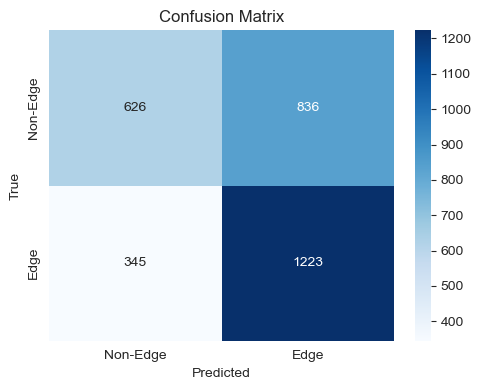

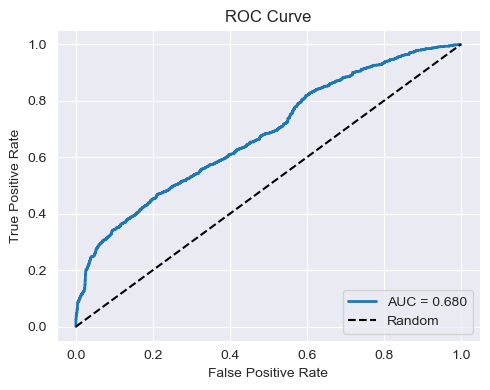

In [16]:
# Step 8: Visualize results
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Edge', 'Edge'], yticklabels=['Non-Edge', 'Edge'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- ROC Curve and AUC ---
y_proba = clf.predict_proba(X_test)[:, 1]  # Probability for class '1'
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()